Dans ce notebook nous allons effectuer une classificiation sur la gravité des accidents pour chaque année afin de savoir les facteurs qui influent cette gravité.

# Modèle de prédiction de la gravité des accidents par année :

## Année 2005 : 

#### Required libraries :

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [83]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)
col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data2005=data2005.loc[:,col_used]

Avant d'effectuer l'apprentissage, nous devons passer par une étape très importante : le codage des variable.

En effet, dans notre trame de donnée on dispose soit des variable numériques ( age, pr1, ..) soit des variable nominales ( lum, int, ..). Donc le fait de laisser les variables nominale codées en entier sera interprété par les algorithmes comme étant des variables ordinales ou numériques. Pour éviter ce genre de problème on va effectuer ce qu'on appele le One-Hot Encoding en utilisant la fonction get_dummies. Mais avant d'appliquer cette méthode, il faut spécifier que ces variables sont bien nominale via le changement de type de (float,int) vers (object).

In [85]:
#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)

data2005.age=data2005.age.astype(float)
# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data
#get dummies for feature data :
X=pd.get_dummies(X,prefix_sep='_')

Il reste une seule étape et c'est fini, c'est la normalisation de la variable age. En effet, la normalisation va consister à prendre le logarithme de la variable en question. Ceci est importante dans la mesure  ou toutes les variables sont binaire sauf l'âge.

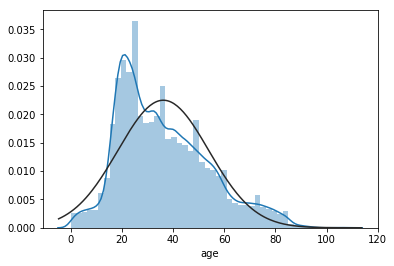

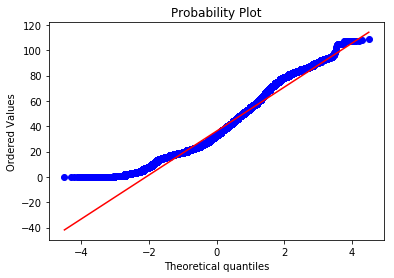

In [71]:
from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
sns.distplot(X['age'], fit=norm);
fig = plt.figure()
res = stats.probplot(X['age'], plot=plt)
plt.show()

Dans ce cas, l'âge  a une variance numérique élevée, et par conséquent on applique le  logarithme sur cette variable. 

In [57]:
X['age'] = np.log1p(X['age'])

Maintenant les données sont prêtes pour être modélisées :

### 1. Sélection des variables en utilisant RandomForest :

#### 1.1 Avec codage des variable catégorielles :

In [89]:
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

Confusion matrix: 
 [[19495    48  1148  3513]
 [  277   117   822   415]
 [ 2299   206  4339  5267]
 [ 5704    95  3743 11761]]
Classification report: 
              precision    recall  f1-score   support

          1       0.70      0.81      0.75     24204
          2       0.25      0.07      0.11      1631
          3       0.43      0.36      0.39     12111
          4       0.56      0.55      0.56     21303

avg / total       0.58      0.60      0.59     59249



voyons maintenant l'importance des variables par ordre décroissant :

L'age, secu, catu, manv,obs, lum, choc,catv,trajet,obsm,catr,prof, catv,int, circ et sexe sont variables importantes (on peut ajouter d'autres mais ces variables sont déjà bonnes). 

Pour justifier, on va élaborer un modèle en utilisant que ces variables puis on comparera les performance.

In [96]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)
col_used =['lum','int', 'catr', 'circ', 'prof', 'catv',
       'obs',  'choc','obsm' ,'manv',  'catu',
       'grav', 'sexe', 'trajet', 'secu', 'age']
data2005=data2005.loc[:,col_used]
#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)

data2005.age=data2005.age.astype(float)
# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data
X['age'] = np.log1p(X['age']) # normalize age
#get dummies for feature data :
X=pd.get_dummies(X,prefix_sep='_')

In [99]:
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)


Confusion matrix: 
 [[18682   107  1376  4039]
 [  247   151   794   439]
 [ 2346   303  4258  5204]
 [ 5677   196  4089 11341]]
Classification report: 
              precision    recall  f1-score   support

          1       0.69      0.77      0.73     24204
          2       0.20      0.09      0.13      1631
          3       0.40      0.35      0.38     12111
          4       0.54      0.53      0.54     21303

avg / total       0.57      0.58      0.57     59249



Toujours l'âge est en tête de la liste.

 Parfait les résultats sont quasiment les mêmes avec quelques diminution pour les modalités ( indemne et tué) et quelques améliorations les autres modalitées ( blessé léger/hospitalisé).

Rq: la condition atmosphériques n'influe pas la gravité des accidents. Ceci peut être expliqué par le fait que si le climat n'est pas bon, il y a peu de monde qui sont motivés pour conduire  et donc dimunie le trafic et par conséquent les accidents.

#### 1.2 Sans codage des variable catégorielles :

In [101]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']

data2005=data2005.loc[:,col_used]

#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)
data2005.age=data2005.age.astype(float)

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [102]:
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

Confusion matrix: 
 [[19534    44  1059  3567]
 [  268   121   800   442]
 [ 2265   196  4478  5172]
 [ 5735    77  3843 11648]]
Classification report: 
              precision    recall  f1-score   support

          1       0.70      0.81      0.75     24204
          2       0.28      0.07      0.12      1631
          3       0.44      0.37      0.40     12111
          4       0.56      0.55      0.55     21303

avg / total       0.59      0.60      0.59     59249

age = 0.179075484821
catv = 0.0868843858879
manv = 0.0715285459199
choc = 0.0582300630943
col = 0.0537165914648
secu = 0.0468587064404
catr = 0.0441793863598
trajet = 0.0421973193249
obsm = 0.038374227494
obs = 0.0376803612264
lum = 0.036406729712
int = 0.0349242030718
circ = 0.0276351720882
atm = 0.0274859142637
prof = 0.0274366547812
plan = 0.0251772052819
surf = 0.0235926258383
catu = 0.0223828979912
place = 0.0202016303455
infra = 0.0196696581072
sexe = 0.0181417919637
etatp = 0.0158034489939
actp = 0.0121485533999


On remarque que même sans codage des variables catégorielles on obtient de bonnes résultats avec une légére différence au niveau des importances des variables. Mais il faut faire attention car ceci parfois n'est pas optimale.

In [109]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'catr', 'circ', 'prof', 'catv',
       'obs',  'choc','obsm' ,'manv',  'catu','col',
       'grav', 'sexe', 'trajet', 'secu', 'age']

data2005=data2005.loc[:,col_used]

#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)
data2005.age=data2005.age.astype(float)

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4,n_jobs=-1,n_estimators=20)
#fit model
rf.fit(x_train,y_train)
#predict on unseen data :
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( rf.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Confusion matrix: 
 [[19205    76  1220  3703]
 [  263   143   773   452]
 [ 2243   265  4313  5290]
 [ 5621   158  4024 11500]]
Classification report: 
              precision    recall  f1-score   support

          1       0.70      0.79      0.75     24204
          2       0.22      0.09      0.13      1631
          3       0.42      0.36      0.38     12111
          4       0.55      0.54      0.54     21303

avg / total       0.58      0.59      0.58     59249

age = 0.237073384445
manv = 0.0870261913304
catv = 0.076421220053
choc = 0.0668144519297
col = 0.0603659452245
catu = 0.0589793585541
secu = 0.0584824404928
catr = 0.0489562624074
trajet = 0.0484250919431
lum = 0.0442471100546
obsm = 0.041659727535
int = 0.0409407054428
obs = 0.0409397413311
prof = 0.0340319750344
circ = 0.0337136447068
sexe = 0.0219227495152


##### Arbre de décision pour une bonne visualisation des résultats : 

In [113]:
#load data
data2005=pd.read_csv('data1.csv',encoding='latin-1')
# let's first create an attribute age :
data2005.loc[:,['an']]=data2005.loc[:,['an']]+2000
data2005['age']=pd.Series(data2005.an.values - data2005.an_nais.values)
#choose features to use for classification  : 
#( we delete all spatiale features: lon/lat/dep/com/addresse/agg/voie/v1/v2 ..)
# we delete an/mois/jours ( later we will do feature engineering to creata a variable for the number of the day in the week 
#to see the effet of weekend ...)

col_used =['lum','int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'place', 'catu',
       'grav', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 
       'age']
data2005=data2005.loc[:,col_used]

#change types :
for col in col_used :
    data2005[col]=data2005[col].astype(str)
data2005.age=data2005.age.astype(float)

# split data into target and feature data :
y=data2005.grav.values  # target column
X=data2005.loc[:,data2005.columns!='grav']  # feature data

X['age'] = np.log1p(X['age']) # normalize age
#required  libraries :
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#split data into train/test data :
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)
dt = DecisionTreeClassifier(random_state = 4,max_depth=6)
#fit model
dt.fit(x_train,y_train)
#predict on unseen data :
y_pred = dt.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
for  importance,name in sorted(list(zip( dt.feature_importances_,list(X.columns))),reverse=True):
    print(name, "=", importance)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Confusion matrix: 
 [[19997     2   241  3964]
 [  394     3   512   722]
 [ 2725     4  1934  7448]
 [ 6405     2  1394 13502]]
Classification report: 
              precision    recall  f1-score   support

          1       0.68      0.83      0.74     24204
          2       0.27      0.00      0.00      1631
          3       0.47      0.16      0.24     12111
          4       0.53      0.63      0.58     21303

avg / total       0.57      0.60      0.56     59249

obsm = 0.237073384445
surf = 0.0870261913304
circ = 0.076421220053
prof = 0.0668144519297
situ = 0.0603659452245
infra = 0.0589793585541
obs = 0.0584824404928
atm = 0.0489562624074
catv = 0.0484250919431
lum = 0.0442471100546
plan = 0.041659727535
int = 0.0409407054428
vosp = 0.0409397413311
catr = 0.0340319750344
col = 0.0337136447068
senc = 0.0219227495152


In [116]:
# see the tree for our decision tree classification model :
# to see the tree visit link : webgraphviz.com   then copy and paste the contente of tree.txt in the cell given 
from sklearn import tree
tree.export_graphviz(dt,out_file="tree.txt",impurity = True,
                            feature_names = list(X.columns),
                            class_names = ['Indemne', 'Tué','BlesseHospitalisé','Blesséléger'],
                            rounded = True,
                            filled= True )

### 2. Sélection des variables en utilisant Gradient Boosting:

Cette partie a pour but de confirmer la séléction des variable en utilisant l'algorithme GB